In [1]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans

In [40]:
testFile = arff.loadarff('KDDTest+.arff')
trainFile = arff.loadarff('KDDTrain+.arff')
t = pd.read_csv("KDDTrain+_20Percent.txt")
testDF = pd.DataFrame(testFile[0])
trainDF = pd.DataFrame(trainFile[0])

In [6]:
testDF.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,b'tcp',b'private',b'REJ',0.0,0.0,b'0',0.0,0.0,0.0,...,10.0,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,b'anomaly'
1,0.0,b'tcp',b'private',b'REJ',0.0,0.0,b'0',0.0,0.0,0.0,...,1.0,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,b'anomaly'
2,2.0,b'tcp',b'ftp_data',b'SF',12983.0,0.0,b'0',0.0,0.0,0.0,...,86.0,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,b'normal'
3,0.0,b'icmp',b'eco_i',b'SF',20.0,0.0,b'0',0.0,0.0,0.0,...,57.0,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,b'anomaly'
4,1.0,b'tcp',b'telnet',b'RSTO',0.0,15.0,b'0',0.0,0.0,0.0,...,86.0,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,b'anomaly'


In [7]:
trainDF.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,b'tcp',b'ftp_data',b'SF',491.0,0.0,b'0',0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,b'normal'
1,0.0,b'udp',b'other',b'SF',146.0,0.0,b'0',0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,b'normal'
2,0.0,b'tcp',b'private',b'S0',0.0,0.0,b'0',0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,b'anomaly'
3,0.0,b'tcp',b'http',b'SF',232.0,8153.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,b'normal'
4,0.0,b'tcp',b'http',b'SF',199.0,420.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,b'normal'


In [41]:
t

duration protocol_type  service   flag  src_bytes  dst_bytes  \
0    tcp     ftp_data            SF      491      0          0          0   
     udp        other            SF      146      0          0          0   
     tcp      private            S0        0      0          0          0   
     tcp         http            SF      232   8153          0          0   
     tcp         http            SF      199    420          0          0   
     tcp      private           REJ        0      0          0          0   
     tcp      private            S0        0      0          0          0   
     tcp      private            S0        0      0          0          0   
     tcp   remote_job            S0        0      0          0          0   
     tcp      private            S0        0      0          0          0   
     tcp      private           REJ        0      0          0          0   
     tcp      private            S0        0      0          0          0   
     tcp         http            SF      287   2251          0          0   
     tcp     ftp_data            SF      334      0          0          0   
     tcp         name            S0        0      0          0          0   
     tcp   netbios_ns            S0        0      0          0          0   
     tcp         http            SF      300  13788          0          0   
     icmp       eco_i            SF       18      0          0          0   
     tcp         http            SF      233    616          0          0   
     tcp         http            SF      343   1178          0          0   
     tcp          mtp            S0        0      0          0          0   
     tcp      private            S0        0      0          0          0   
     tcp         http            SF      253  11905          0          0   
5607 udp        other            SF      147    105          0          0   
0    tcp          mtp            S0        0      0          0          0   
507  tcp       telnet            SF      437  14421          0          0   
0    tcp      private            S0        0      0          0          0   
     tcp         http            SF      227   6588          0          0   
     tcp         http            SF      215  10499          0          0   
     tcp         http            SF      241   1400          0          0   
...               ...           ...      ...    ...        ...        ...   
     udp      private            SF      105    147          0          0   
     tcp         smtp            S0        0      0          0          0   
     tcp         http            SF      276    622          0          0   
     tcp         http            SF     2499   2737          0          0   
     tcp          ctf           REJ        0      0          0          0   
     tcp         http            SF      193   2408          0          0   
     tcp         http            SF      252   6160          0          0   
     udp      private            SF      105    146          0          0   
     tcp         smtp            S0        0      0          0          0   
     tcp      private            S0        0      0          0          0   
     tcp       telnet            S0        0      0          0          0   
     udp     domain_u            SF       39     99          0          0   
     tcp          ftp          RSTO        0      0          0          0   
10   tcp       telnet            SF      139   2257          0          0   
0    tcp     ftp_data            SF      748      0          0          0   
     tcp         http            SF      293   2486          0          0   
     tcp      private            S0        0      0          0          0   
     tcp      private            S0        0      0          0          0   
     tcp        vmnet            S0        0      0          0          0   
     icmp       eco_i            SF        8      0          0          0   
     tcp 

In [48]:
train_data = t[['src_bytes', 'dst_bytes', 'num_failed_logins', 'logged_in', 'num_compromised', 
            'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
            'num_access_files', 'num_outbound_cmds']]
# test_data = testDF[['src_bytes', 'dst_bytes', 'num_failed_logins', 'logged_in', 'num_compromised', 
#             'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
#             'num_access_files', 'num_outbound_cmds']]

In [49]:
model4=KMeans(n_clusters=4)
model4.fit(train_data)
clusassign=model4.predict(train_data)

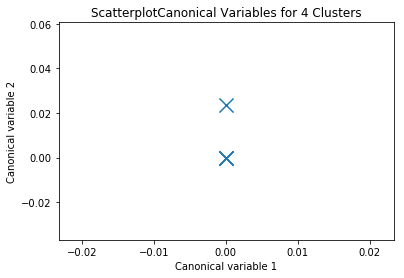

In [50]:
# plot the centroids
centroids = model4.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1], marker='o', s = 200, linewidths=2, c='none')
plt.scatter(centroids[:,0],centroids[:,1], marker='x', s = 200, linewidths=2)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('ScatterplotCanonical Variables for 4 Clusters')
plt.show()

In [2]:
kaggle_dataset = pd.read_csv("cs448b_ipasn.csv")

In [3]:
kaggle_dataset

,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
1,2006-07-01,0,714,1
2,2006-07-01,0,1239,1
3,2006-07-01,0,1680,1
4,2006-07-01,0,2514,1
5,2006-07-01,0,3320,1
6,2006-07-01,0,3561,13
7,2006-07-01,0,4134,3
8,2006-07-01,0,5617,2
9,2006-07-01,0,6478,1


In [46]:
k_model = KMeans(n_clusters=4)
k_model.fit(kaggle_dataset[["l_ipn","r_asn","f"]])
clusassign=k_model.predict(kaggle_dataset[["l_ipn","r_asn","f"]])

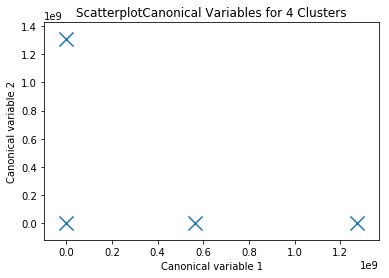

In [47]:
centroids = model4.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1], marker='o', s = 200, linewidths=2, c='none')
plt.scatter(centroids[:,0],centroids[:,1], marker='x', s = 200, linewidths=2)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('ScatterplotCanonical Variables for 4 Clusters')
plt.show()